In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader 
import random
import tqdm

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
df = pd.read_csv("../data/interim/small_10000_orders_weighted_adjacency_matrix.csv", nrows=2000)
df["rating"] = df.weight

5 Most Purchased Products:
     product_id  weight
388       13176      87
525       17794      59
693       22935      55
805       26369      50
800       26209      48


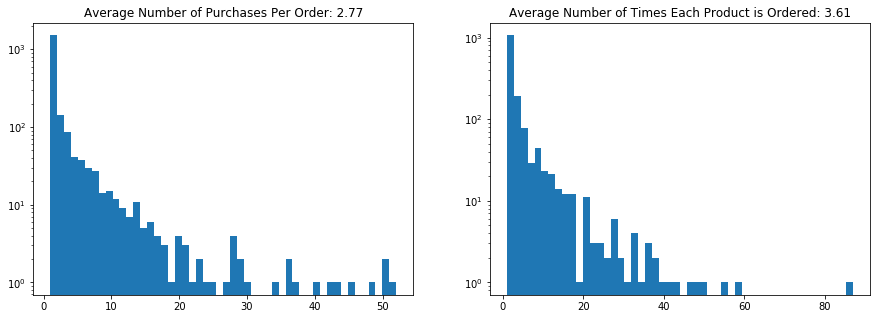

In [5]:
df_grouped = df[["product_id", "weight"]].groupby(["product_id"]).sum()
df_grouped.reset_index(inplace=True)
print(f"5 Most Purchased Products:\n{df_grouped.sort_values(by='weight', ascending=False).head(5)}")

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.hist(df.weight, bins=50)
ax1.set_yscale('log')
ax1.set_title(f"Average Number of Purchases Per Order: {df.weight.mean():.2f}")

ax2.hist(df_grouped.weight, bins=50)
ax2.set_title(f"Average Number of Times Each Product is Ordered: {df_grouped.weight.mean():.2f}")
ax2.set_yscale('log')

plt.show()

## Collaborative Filtering

For the models we will want to use a numberic index rather than the product_id and user_id so that we can easily match the embedding vector with the user or product.

In [27]:
def list_to_indexed_dict(list_):
    return dict(enumerate(sorted(set(list_))))


class RatingsDataset(Dataset):
    """
    User, product, ratings dataset. 
    """
    def __init__(self, dataframe, product_dict, user_dict, 
                 dev=torch.device("cpu"), reweighting=dict()):
        """
        Args:
            dataframe (pandas.DataFrame): Dataframe containing ratings.
            product_dict (dict): Dictionary mapping product ids to indices.
            user_dict (dict): Dictionary mapping user ids to indices.
            reweighting (dict, optional): Dictionary mapping ratings to new values.
            dev (torch device): Hardware that the model should run on.
        """
        super(RatingsDataset, self).__init__()
        self.df = dataframe
        self.p_dict = product_dict
        self.u_dict = user_dict
        self.w_dict = reweighting
        self.dev = dev


    def __len__(self):
        return len(self.df)
    

    def __getitem__(self, idx):
        """
        Get and return Tensor for item, user, ratings triplet
        """
        item = self.transform(self.df["product_id"].iloc[idx], self.p_dict)
        user = self.transform(self.df["user_id"].iloc[idx], self.u_dict)
        rating = self.transform(self.df["rating"].iloc[idx], self.w_dict)

        return (item, user, rating)

    def transform(self, df_rows, mapping):
        """
        Replace dataframe with index values and convert to torch.Tensor
        """
        transformed = pd.Series(df_rows).replace(mapping).to_numpy()
        return torch.from_numpy(transformed).to(self.dev)


def dataframe_split(df, train_frac=0.80, test_frac=0.10):
    """Split dataframe into training, testing, and validation sets."""
    train_df = df.sample(frac=train_frac, random_state=23)
    test_df = df.drop(train_df.index).sample(int(test_frac * len(df)),
                                            random_state=23)
    val_df = df.drop(pd.concat([train_df, test_df], axis=0).index)

    return train_df, val_df, test_df


class MatrixFactorization(torch.nn.Module):
    """Matrix factorization using pytorch"""
    def __init__(self, n_users, n_products, n_factors=20):
        """
        Initalize the user and product embedding vectors in latent space.
        
        Args:
            n_users (int): Number of users with prior purchases.
            n_products (int): Total number of products purchased.
            n_factors (integer, optional): Dimension of the latent embedding space.
        """
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors, sparse=True)
        self.product_factors = nn.Embedding(n_products, n_factors, sparse=True)
        self.user_bias = nn.Embedding(n_users, 1)
        self.product_bias = nn.Embedding(n_products, 1)


    def forward(self, user, item):
        """ Matrix multiplication between user and product embedding vectors."""
        bias = self.user_bias(user).squeeze() + self.product_bias(item).squeeze()
        matrix = ((self.user_factors(user)) * (self.product_factors(item))).squeeze().sum(1)
        
        return matrix + bias


In [28]:
index_to_product_dict = list_to_indexed_dict(df.product_id)
index_to_user_dict = list_to_indexed_dict(df.user_id)

product_to_index_dict = {key: value for value, key in index_to_product_dict.items()}
user_to_index_dict = {key: value for value, key in index_to_user_dict.items()}

train_df, val_df, test_df = dataframe_split(df)
reweight_dict = {val:1.0 for val in df.weight.unique()}

train_data = RatingsDataset(train_df, product_to_index_dict, user_to_index_dict,
                            reweighting=reweight_dict, dev=dev)
val_data = RatingsDataset(val_df, product_to_index_dict, user_to_index_dict,
                          reweighting=reweight_dict, dev=dev)
test_data = RatingsDataset(test_df, product_to_index_dict, user_to_index_dict,
                           reweighting=reweight_dict, dev=dev)

In [29]:
n_users, n_products = len(user_to_index_dict), len(product_to_index_dict)

model = MatrixFactorization(n_users, n_products, n_factors=50)
model.to(dev)
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

bs = 10
epochs = 200
print_every = 5

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

for epoch in range(epochs):
    # training
    train_loss = 0
    model.train()
    for item, user, rating in train_loader:
        prediction = model(user, item)
        loss = loss_fn(prediction, rating.float())
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = [
            loss_fn(model(user, item), rating.float()).item()
            for item, user, rating in val_loader
        ]
        
        val_loss = np.sum(val_loss)
    
    if (epoch + 1) % print_every == 0:
        print(f"epoch #{epoch + 1}, training loss: {train_loss:0.3f}, validation loss: {val_loss:0.3f}")
        


epoch #5, training loss: 2810.336, validation loss: 729.402
epoch #10, training loss: 3697.991, validation loss: 1212.410
epoch #15, training loss: 3057.437, validation loss: 790.250
epoch #20, training loss: 4997.583, validation loss: 1289.980
epoch #25, training loss: 4492.655, validation loss: 962.677
epoch #30, training loss: 6560.888, validation loss: 954.225
epoch #35, training loss: 12862.202, validation loss: 1372.815
epoch #40, training loss: 18751.822, validation loss: 1556.452
epoch #45, training loss: 46857.493, validation loss: 3617.753
epoch #50, training loss: nan, validation loss: nan
epoch #55, training loss: nan, validation loss: nan
epoch #60, training loss: nan, validation loss: nan
epoch #65, training loss: nan, validation loss: nan
epoch #70, training loss: nan, validation loss: nan
epoch #75, training loss: nan, validation loss: nan
epoch #80, training loss: nan, validation loss: nan
epoch #85, training loss: nan, validation loss: nan
epoch #90, training loss: na

In [30]:
users_items = model.user_factors.weight @ model.product_factors.weight.transpose(0,1)
values = users_items.detach().numpy()

/home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/moveable_data/instacart/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


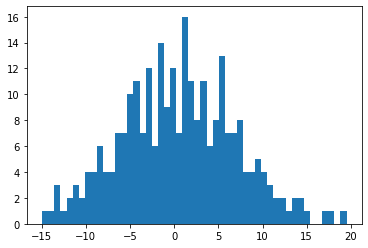

In [31]:
plt.hist(values.ravel(), bins=50)
plt.show()

In [ ]:
def recommend_item_for_user(model, user_id):
    """
    
    """
    m = model.eval().cpu()
    
    user_ids = torch.LongTensor([user2idx[u] for u in [user_id] * len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])
    
    remove = set(ratings[ratings[user_col] == user_id][item_col].values)
    
    preds = m(user_ids,item_ids).detach().numpy()
    pred_item = [(p,b) for p,b in sorted(zip(preds, items), reverse = True) if b not in remove]
    
    return pred_item


def recommend_user_for_item(model, item_id):
    """
    
    """
    m = model.eval().cpu()
    
    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id]*len(users)])
    
    remove = set(ratings[ratings[item_col] == book_id][user_col].values)
    
    preds = m(user_ids,item_ids).detach().numpy()
    pred_user = [(p,u) for p,u in sorted(zip(preds,users), reverse = True) if u not in remove]
    
    return pred_user

